In [1]:
import os
import joblib
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

## STEP 1: Connect to MongoDB Atlas

In [2]:
load_dotenv()
# Retrieve MongoDB URI from environment variables
mongo_uri = os.getenv("MONGO_DB_URI")
if not mongo_uri:
    raise ValueError("MongoDBUrl not found in .env file")

# Connect to MongoDB Atlas
client = MongoClient(mongo_uri)
db = client["employeeverse"]  # Database name
collection = db["employee"]    # Collection name

cursor = collection.find({})
employees = pd.DataFrame(list(cursor))

## Step 2: Drop unnecessary columns

In [ ]:
irrelevant_columns = ["_id", "regdNo", "designation", "email", "password", "genderCode"]
employees.drop(columns=irrelevant_columns, inplace=True, errors="ignore")

# Print dataset after dropping irrelevant columns
print("Dataset after dropping non-relevant columns:")
print(employees.head())

Dataset after dropping non-relevant columns:
   employeeId          username firstName lastName  performanceScore  \
0           1      justinhuang1    Justin    Huang                74   
1           2  michellestewart2  Michelle  Stewart                58   
2           3     michaelwhite3   Michael    White                93   
3           4        sarahboyd4     Sarah     Boyd                73   
4           5         lisabarr5      Lisa     Barr                77   

   attendanceScore  peerFeedbackScore  managerRating  overtimeScore  \
0               75                 81             93             28   
1               68                 55             75             66   
2              100                 93             90             81   
3               66                 84             86             67   
4               61                 64             82             31   

   innovationScore  leadershipScore  customerFeedbackScore  \
0               78               

In [4]:
print("\nDataset Info:")
print(employees.info())
print("\nMissing Values:")
print(employees.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   employeeId                10000 non-null  int64 
 1   username                  10000 non-null  object
 2   firstName                 10000 non-null  object
 3   lastName                  10000 non-null  object
 4   performanceScore          10000 non-null  int64 
 5   attendanceScore           10000 non-null  int64 
 6   peerFeedbackScore         10000 non-null  int64 
 7   managerRating             10000 non-null  int64 
 8   overtimeScore             10000 non-null  int64 
 9   innovationScore           10000 non-null  int64 
 10  leadershipScore           10000 non-null  int64 
 11  customerFeedbackScore     10000 non-null  int64 
 12  taskCompletionEfficiency  10000 non-null  int64 
 13  problemSolvingScore       10000 non-null  int64 
dtypes: int64

## STEP 3: Feature Selection & Preprocessing

In [5]:
ml_features = [
    "performanceScore", "attendanceScore", "peerFeedbackScore", "managerRating", "overtimeScore",
    "innovationScore", "leadershipScore", "customerFeedbackScore", "taskCompletionEfficiency", "problemSolvingScore"
]

# Normalize scores (0-1 scale)
scaler = MinMaxScaler()
employees[ml_features] = scaler.fit_transform(employees[ml_features])

# Define final ranking score using weighted sum
weights = np.array([0.2, 0.15, 0.1, 0.15, 0.05, 0.1, 0.1, 0.05, 0.05, 0.05])
employees["finalScore"] = employees[ml_features].dot(weights)

## STEP 4: Train-Test Split

In [6]:
X = employees[ml_features]
y = employees["finalScore"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## STEP 5: Train ML Models

In [7]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

best_model = None
best_r2 = -float("inf")

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} - R2 Score: {r2:.4f}, MSE: {mse:.4f}")
    
    if r2 > best_r2:
        best_r2 = r2
        best_model = model

Linear Regression - R2 Score: 1.0000, MSE: 0.0000
Decision Tree - R2 Score: 0.7606, MSE: 0.0026
Random Forest - R2 Score: 0.9230, MSE: 0.0008


## STEP 6: Save the Best Model

In [8]:
joblib.dump(best_model, "best_employee_model.pkl")
print("Best model saved as best_employee_model.pkl")

Best model saved as best_employee_model.pkl


## STEP 7: Identify Top 10 Employees

In [9]:
top_10_employees = employees.nlargest(10, "finalScore")
print("Top 10 Employees of the Year:")
print(top_10_employees[["employeeId", "username", "firstName", "lastName", "finalScore"]])

Top 10 Employees of the Year:
      employeeId             username firstName   lastName  finalScore
7687        7688   stevensullivan7688    Steven   Sullivan    0.856470
7642        7643    michaelwilson7643   Michael     Wilson    0.851339
3935        3936   sarahmiddleton3936     Sarah  Middleton    0.819815
7431        7432          troykim7432      Troy        Kim    0.814571
3479        3480       luiswalker3480      Luis     Walker    0.813292
6359        6360       sheilabell6360    Sheila       Bell    0.813113
6673        6674   jennifertaylor6674  Jennifer     Taylor    0.811500
4669        4670   mitchellmalone4670  Mitchell     Malone    0.809315
8924        8925  feliciamatthews8925   Felicia   Matthews    0.809256
4737        4738    shawnmitchell4738     Shawn   Mitchell    0.805435


## STEP 8: Visualization

C:\Users\samar\AppData\Local\Temp\ipykernel_9612\1423807203.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_10_employees["username"], x=top_10_employees["finalScore"], palette="viridis")


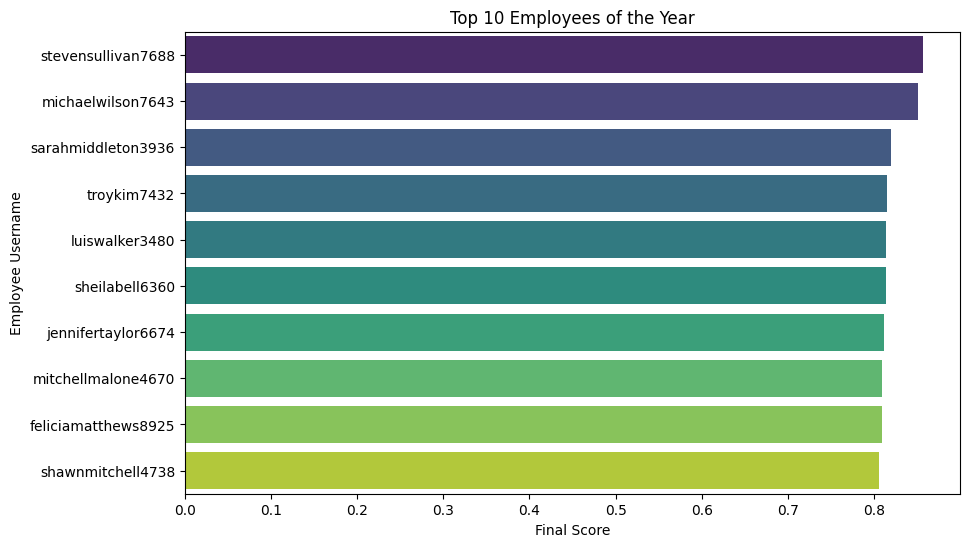

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(y=top_10_employees["username"], x=top_10_employees["finalScore"], palette="viridis")
plt.xlabel("Final Score")
plt.ylabel("Employee Username")
plt.title("Top 10 Employees of the Year")
plt.show()